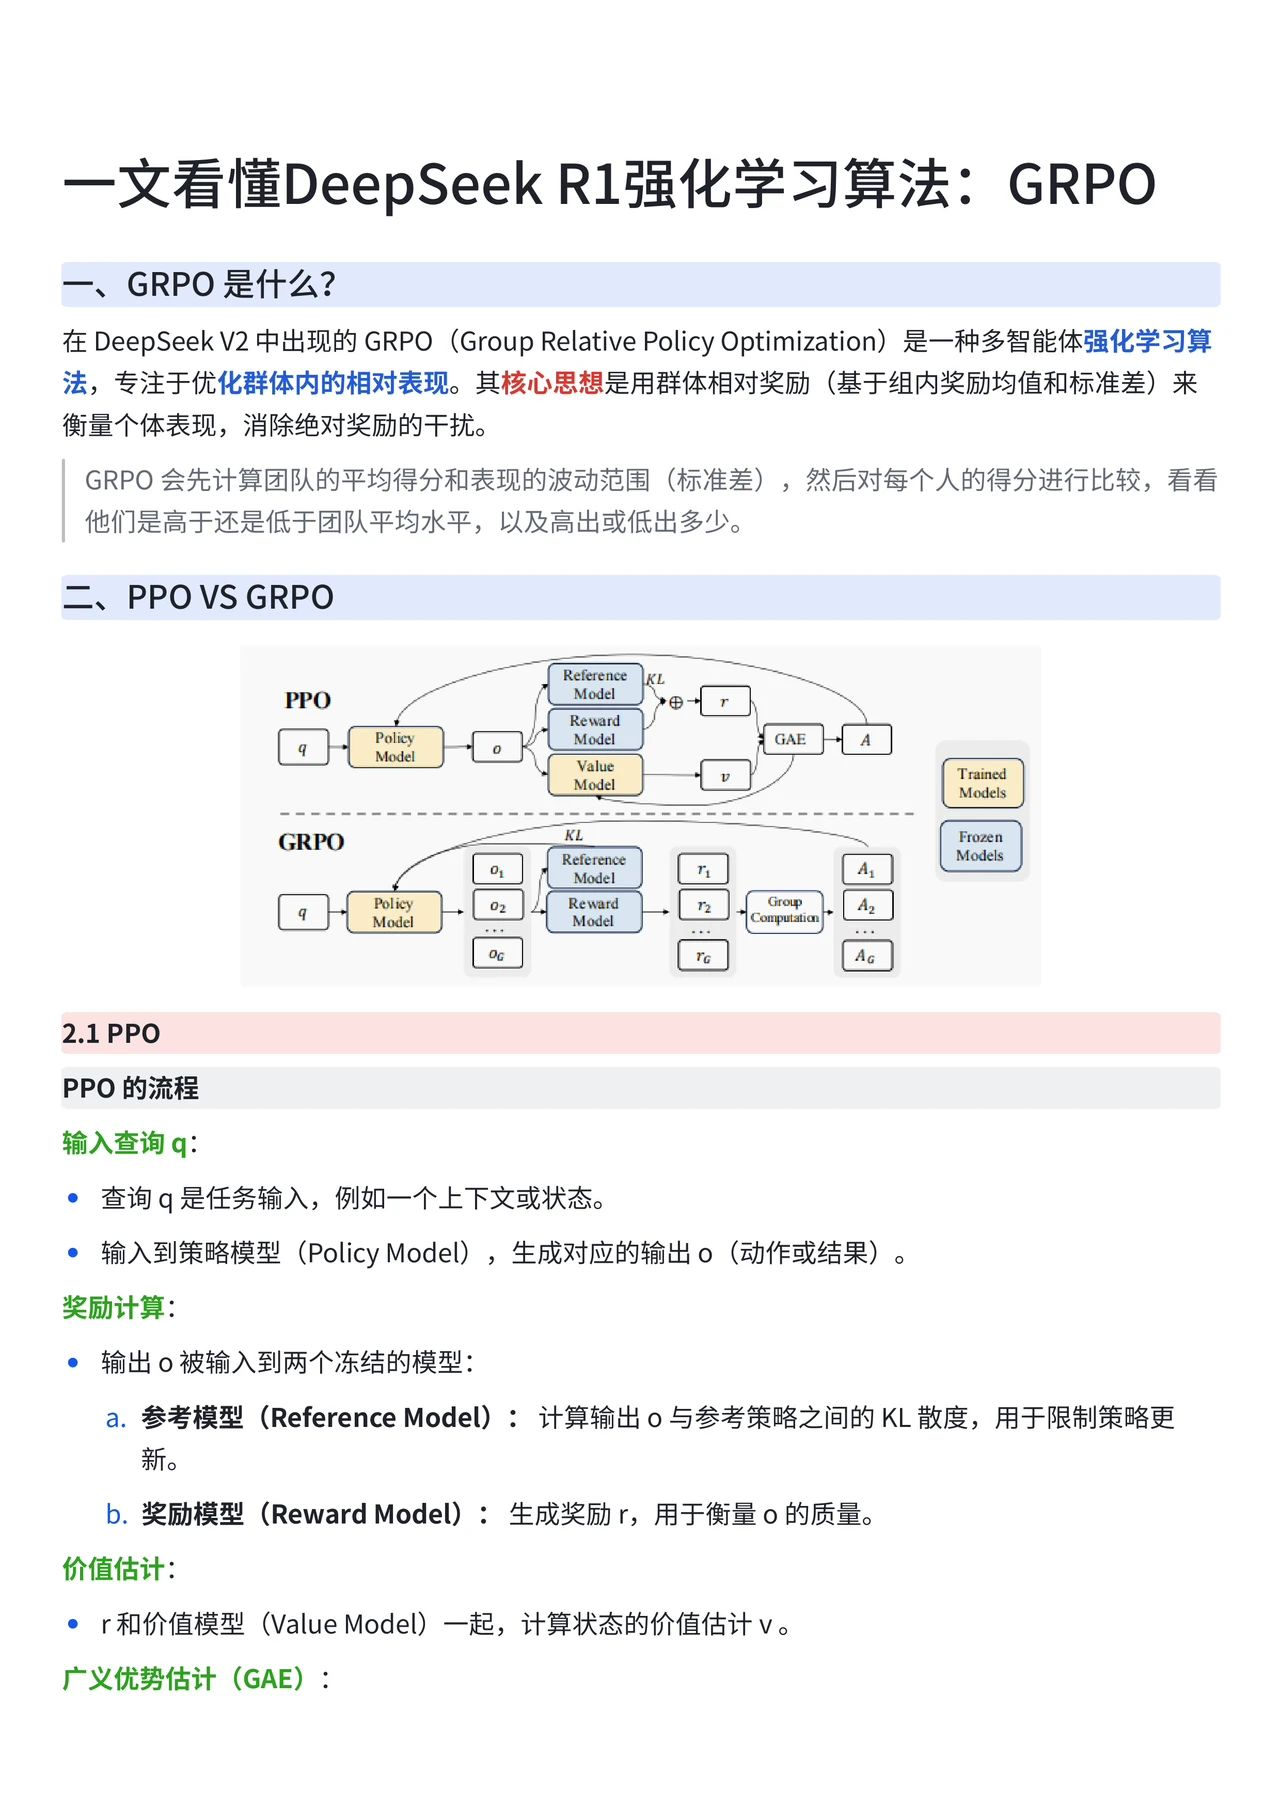

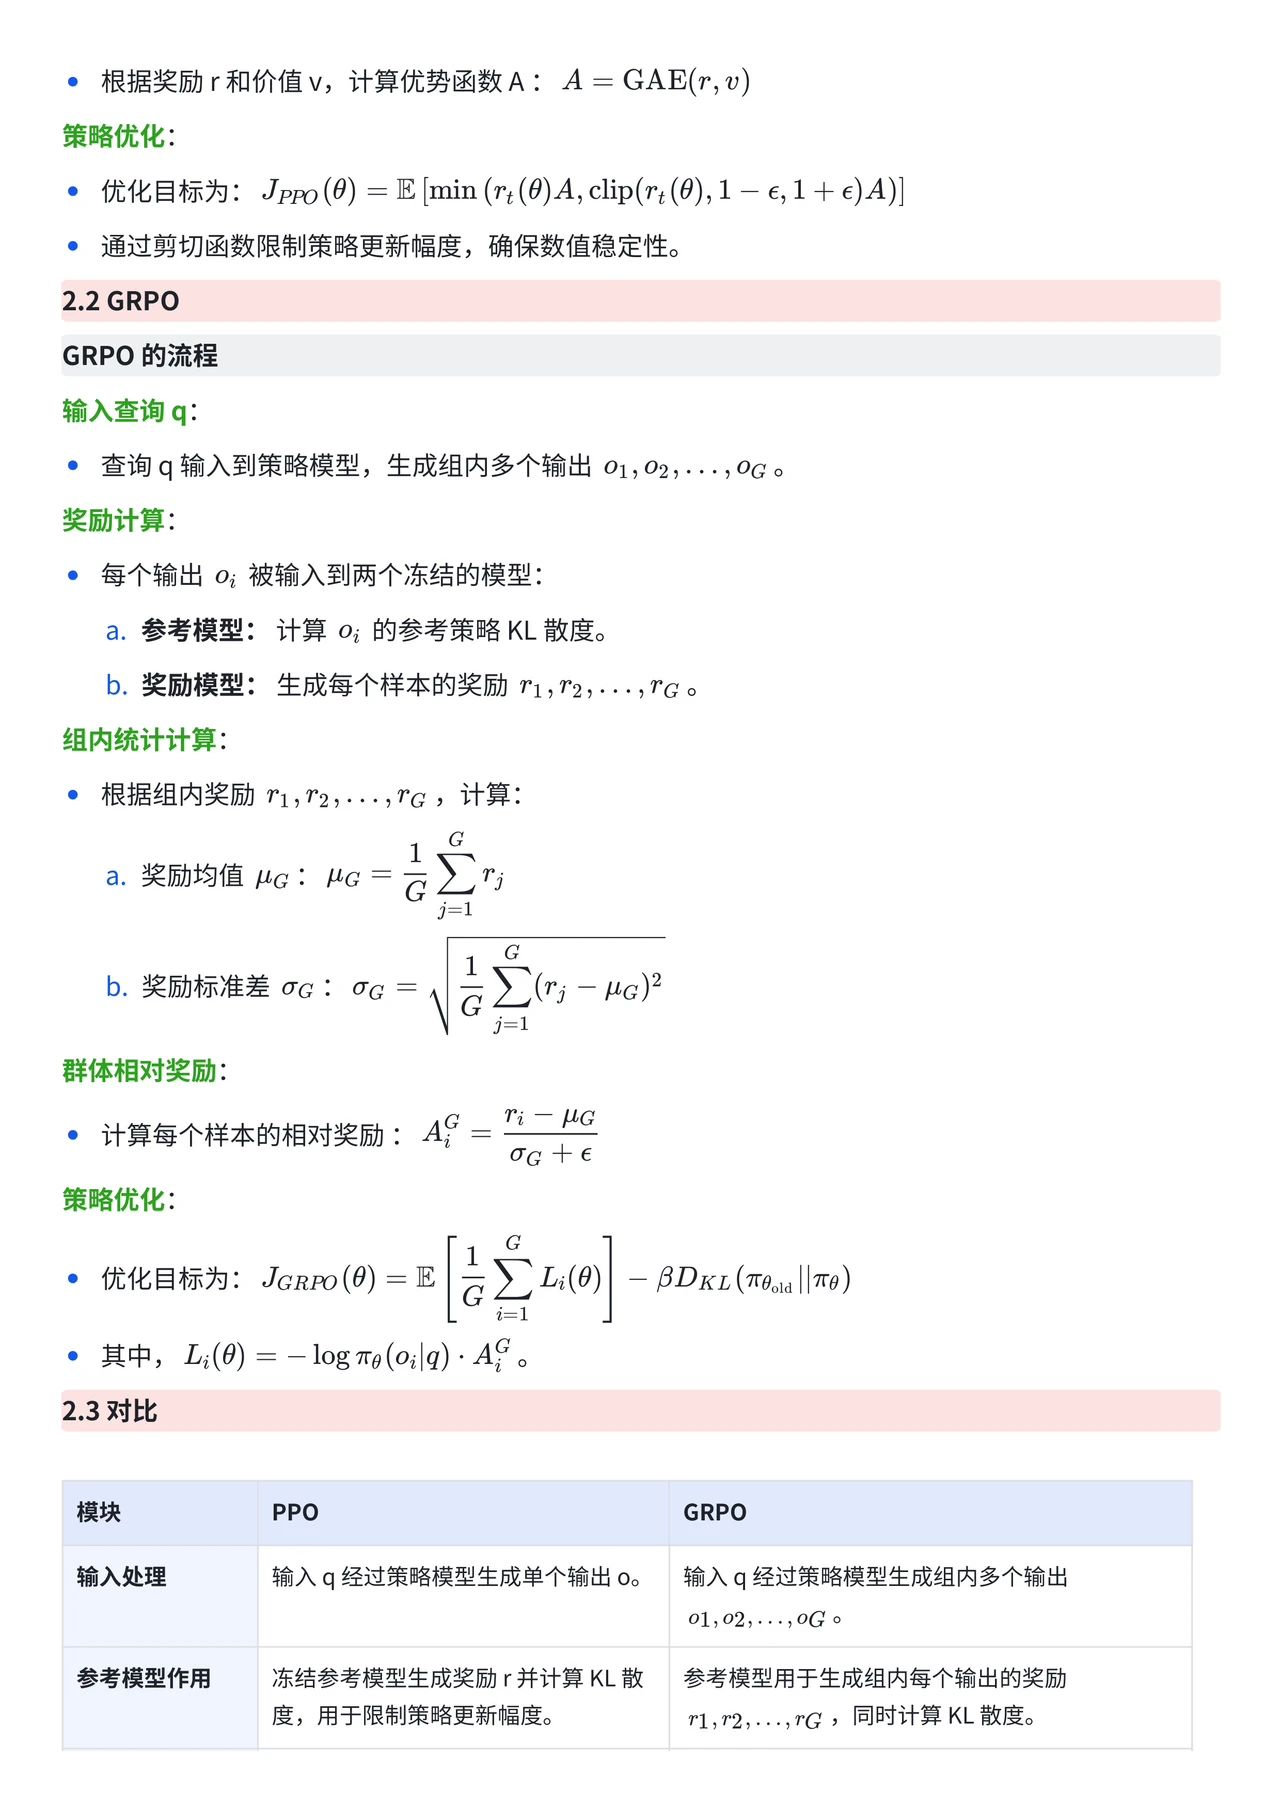
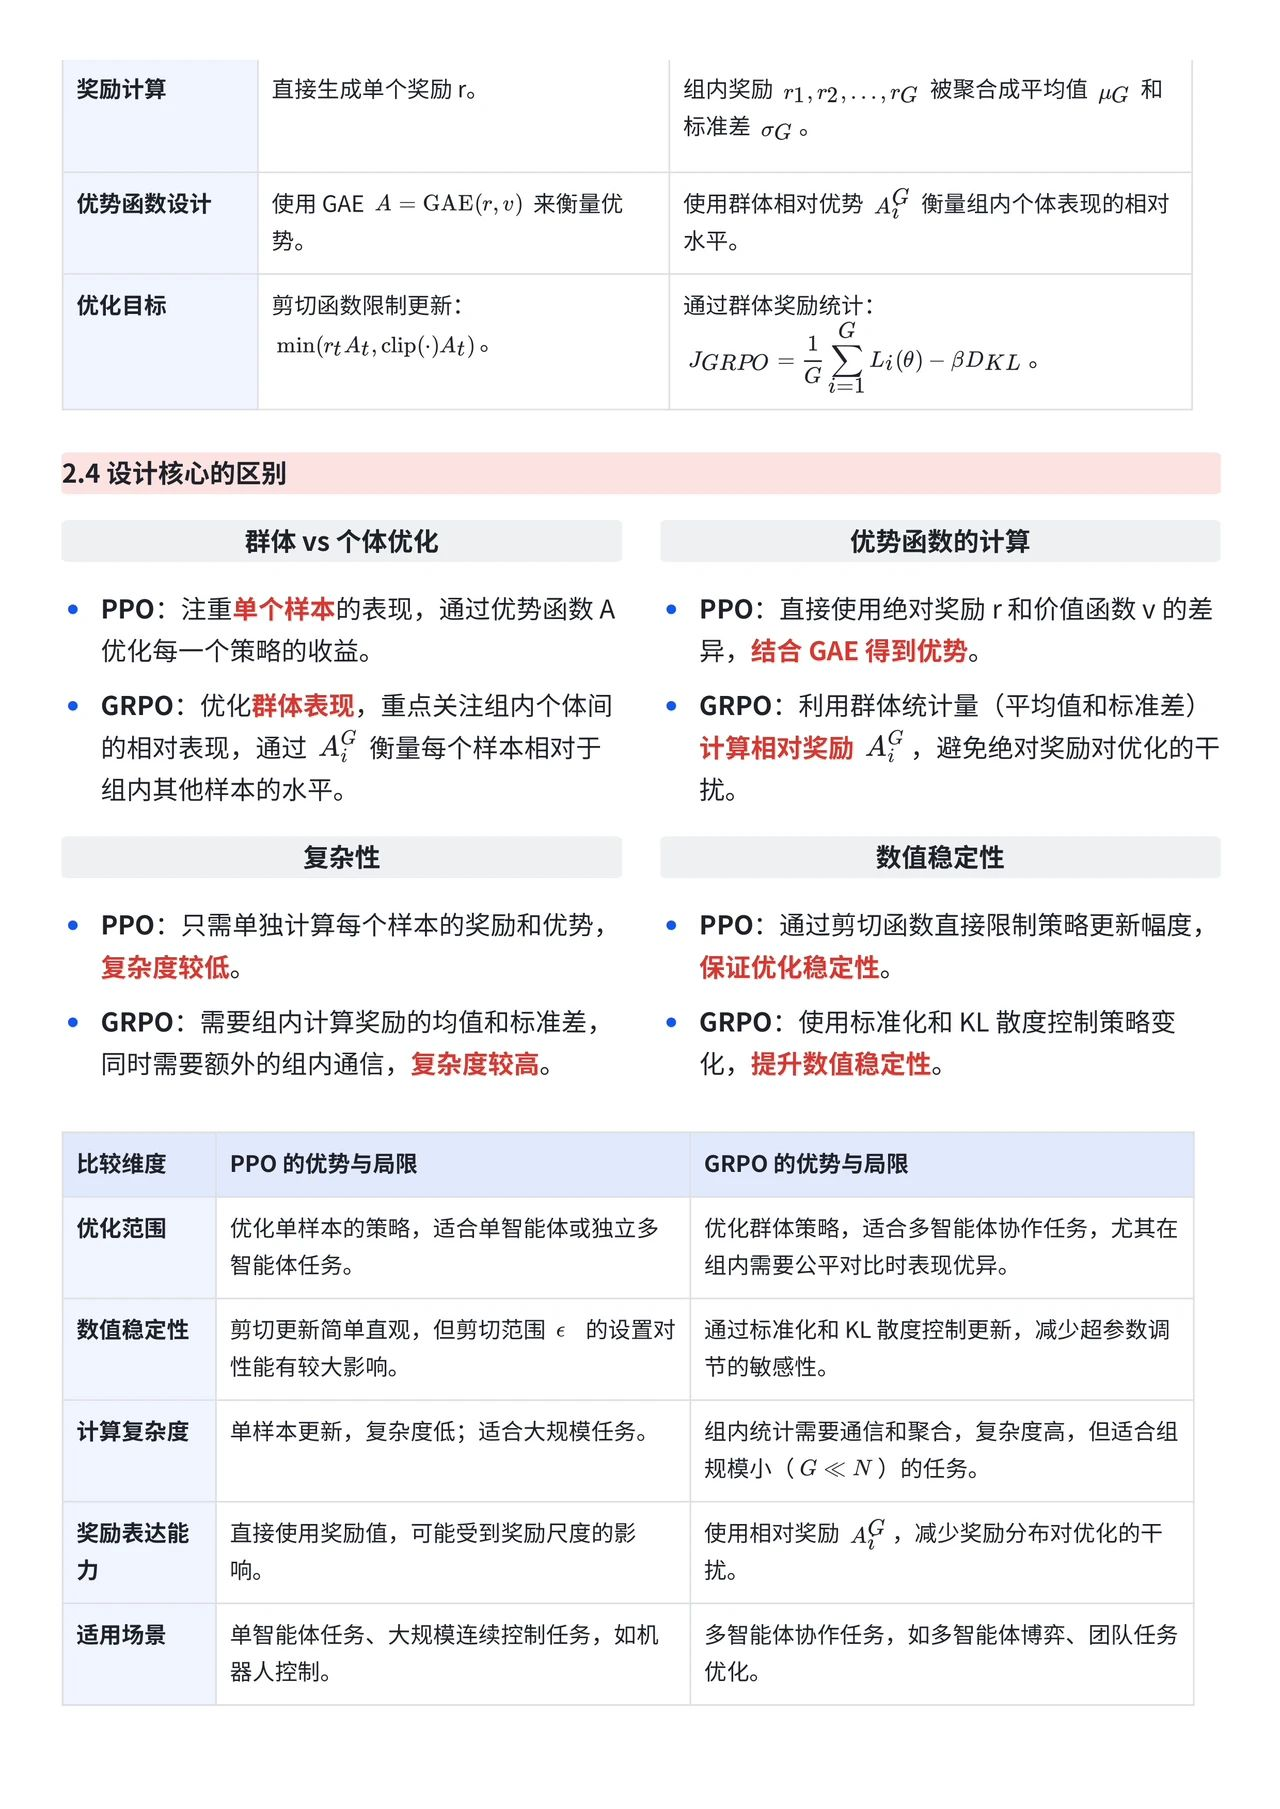

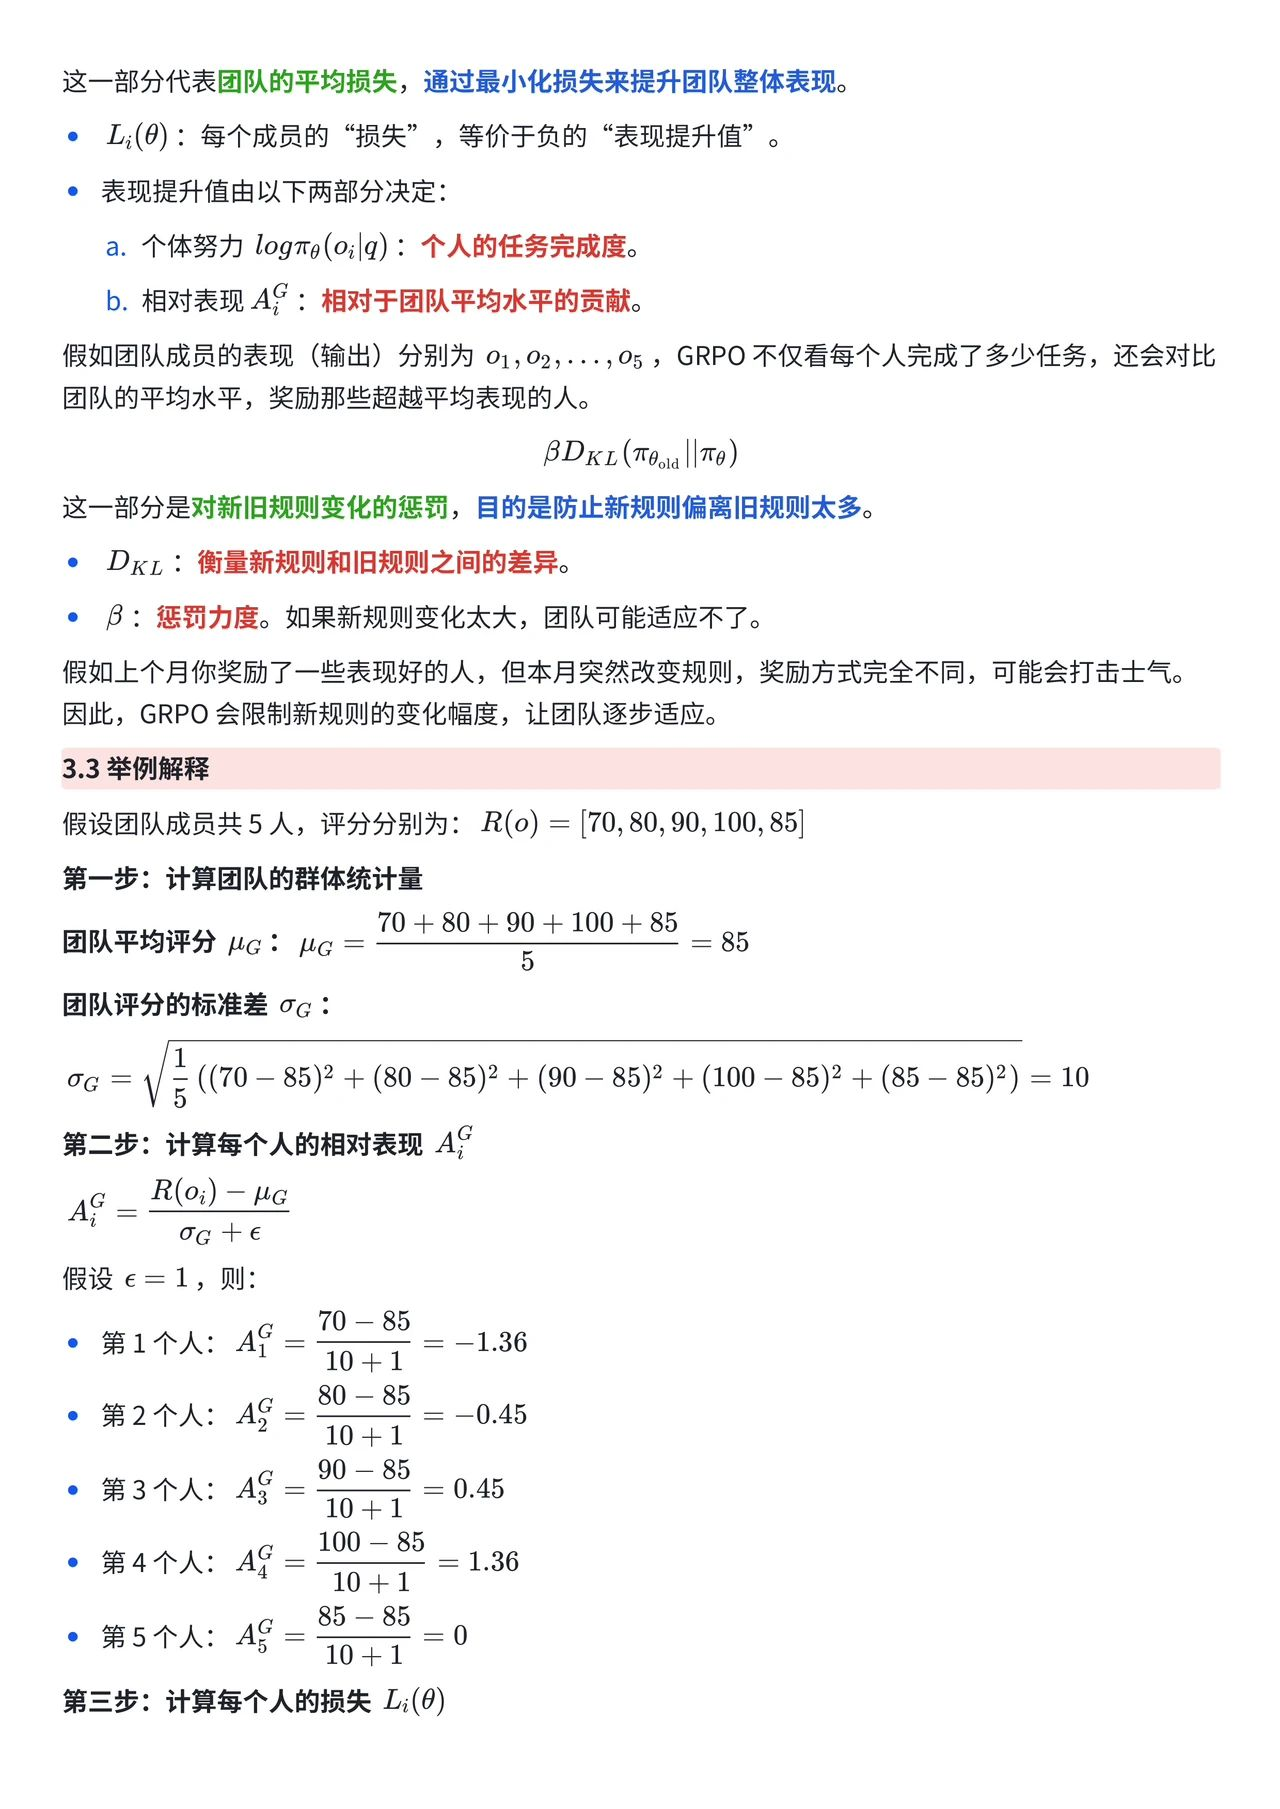

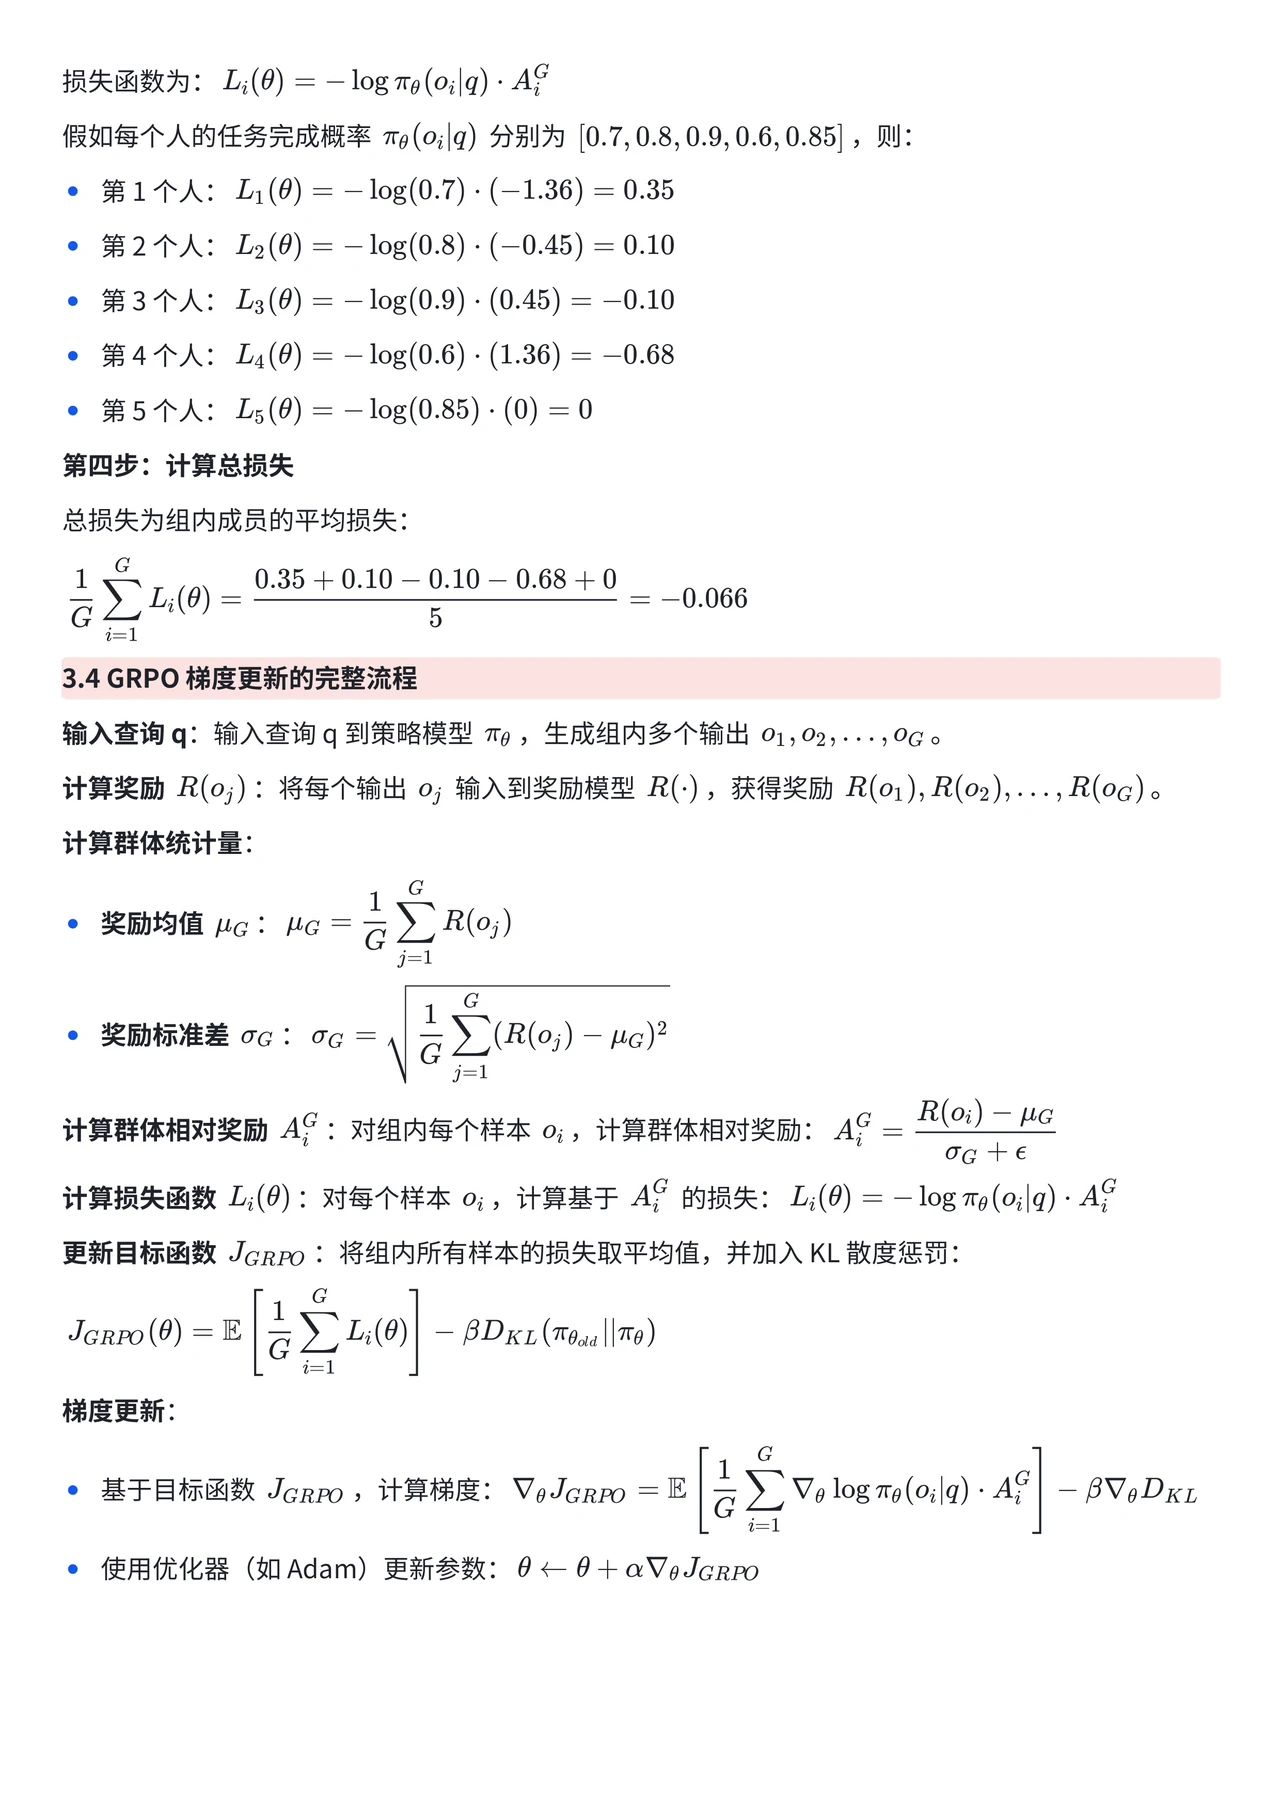

In [9]:
import numpy as np
from scipy.special import softmax, kl_div

# 词汇表及其分组
vocab = ["apple", "banana", "cherry", "date", "elderberry"]
is_vowel = lambda x: x[0].lower() in "aeiou"

class GRPO:
    def __init__(self, vocab, beta=0.1, epsilon=1e-8):
        self.vocab = vocab
        self.vocab_size = len(vocab)
        self.beta = beta  # KL散度的权重系数
        self.epsilon = epsilon  # 防止除零
        
        # 初始化策略参数(logits)
        np.random.seed(42)
        self.theta = np.random.randn(self.vocab_size)
        
    def get_policy_probs(self, logits):
        """获取策略概率分布"""
        return softmax(logits)
    
    def sample_word(self, probs):
        """从概率分布中采样一个词"""
        word_idx = np.random.choice(len(self.vocab), p=probs)
        return word_idx
    
    def compute_reward(self, word_idx):
        """计算奖励（元音开头为1.0，否则为0.0）"""
        word = self.vocab[word_idx]
        return 1.0 if is_vowel(word) else 0.0
    
    def compute_kl_divergence(self, old_probs, new_probs):
        """计算KL散度"""
        return np.sum(kl_div(old_probs, new_probs))
    
    def train(self, num_iterations=50, num_samples=20):
        for iteration in range(1, num_iterations + 1):
            # 1. 输入查询q（这里我们的查询是隐式的，就是选择单词的任务）
            current_probs = self.get_policy_probs(self.theta)
            
            # 2. 收集样本和计算奖励
            outputs = []  # 存储(word_idx, reward)
            rewards = []
            
            for _ in range(num_samples):
                word_idx = self.sample_word(current_probs)
                reward = self.compute_reward(word_idx)
                outputs.append((word_idx, reward))
                rewards.append(reward)
                
            # 3. 组内统计计算
            rewards = np.array(rewards)
            mu_G = np.mean(rewards)  # 奖励均值
            sigma_G = np.std(rewards) + self.epsilon  # 奖励标准差
            
            # 4. 计算每个样本的相对优势
            advantages = [(r - mu_G) / (sigma_G) for _, r in outputs]
            
            # 5. 策略优化
            grad = np.zeros_like(self.theta)
            
            for (word_idx, _), advantage in zip(outputs, advantages):
                # 计算策略梯度
                grad_sample = -current_probs.copy()
                grad_sample[word_idx] += 1.0
                grad += grad_sample * advantage
            
            # 更新策略参数
            learning_rate = 0.01
            self.theta += learning_rate * grad
            
            # 打印当前迭代的统计信息
            new_probs = self.get_policy_probs(self.theta)
            kl_div_value = self.compute_kl_divergence(current_probs, new_probs)
            
            if iteration % 10 == 0:
                print(f"\nIteration {iteration}")
                print("Probabilities:")
                for word, prob in zip(vocab, new_probs):
                    print(f"  {word:12s}: {prob:.3f}")
                print(f"Mean Reward: {mu_G:.3f}")
                print(f"KL Divergence: {kl_div_value:.3f}")

# 运行训练
grpo = GRPO(vocab)
grpo.train()


Iteration 10
Probabilities:
  apple       : 0.361
  banana      : 0.081
  cherry      : 0.163
  date        : 0.285
  elderberry  : 0.110
Mean Reward: 0.500
KL Divergence: 0.001

Iteration 20
Probabilities:
  apple       : 0.613
  banana      : 0.056
  cherry      : 0.094
  date        : 0.131
  elderberry  : 0.106
Mean Reward: 0.650
KL Divergence: 0.002

Iteration 30
Probabilities:
  apple       : 0.775
  banana      : 0.033
  cherry      : 0.052
  date        : 0.058
  elderberry  : 0.082
Mean Reward: 0.950
KL Divergence: 0.000

Iteration 40
Probabilities:
  apple       : 0.861
  banana      : 0.019
  cherry      : 0.032
  date        : 0.030
  elderberry  : 0.058
Mean Reward: 0.850
KL Divergence: 0.000

Iteration 50
Probabilities:
  apple       : 0.918
  banana      : 0.011
  cherry      : 0.017
  date        : 0.016
  elderberry  : 0.038
Mean Reward: 0.900
KL Divergence: 0.000


In [ ]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
from scipy.special import softmax
import plotly.express as px
from scipy.special import softmax, kl_div

# 词汇表及其分组
vocab = ["apple", "banana", "cherry", "date", "elderberry"]
is_vowel = lambda x: x[0].lower() in "aeiou"

class GRPO:
    def __init__(self, vocab, beta=0.1, epsilon=1e-8):
        self.vocab = vocab
        self.vocab_size = len(vocab)
        self.beta = beta
        self.epsilon = epsilon
        
        np.random.seed(42)
        self.theta = np.random.randn(self.vocab_size)
        
        # 添加用于存储训练历史的列表
        self.prob_history = []
        self.reward_history = []
        self.kl_div_history = []
        
    def get_policy_probs(self, logits):
        return softmax(logits)
    
    def sample_word(self, probs):
        word_idx = np.random.choice(len(self.vocab), p=probs)
        return word_idx
    
    def compute_reward(self, word_idx):
        word = self.vocab[word_idx]
        return 1.0 if is_vowel(word) else 0.0
    
    def compute_kl_divergence(self, old_probs, new_probs):
        return np.sum(kl_div(old_probs, new_probs))
    
    def plot_training_progress(self):
        # 创建三个子图
        fig = make_subplots(
            rows=3, cols=1,
            subplot_titles=('Word Probabilities Over Time', 'Mean Reward', 'KL Divergence'),
            vertical_spacing=0.1,
            row_heights=[0.4, 0.3, 0.3]
        )
        
        # 1. 词汇概率随时间变化
        prob_data = np.array(self.prob_history)
        for i, word in enumerate(self.vocab):
            fig.add_trace(
                go.Scatter(x=list(range(len(prob_data))), 
                          y=prob_data[:, i],
                          name=word,
                          mode='lines'),
                row=1, col=1
            )
            
        # 2. 平均奖励变化
        fig.add_trace(
            go.Scatter(x=list(range(len(self.reward_history))),
                      y=self.reward_history,
                      name='Mean Reward',
                      line=dict(color='green')),
            row=2, col=1
        )
        
        # 3. KL散度变化
        fig.add_trace(
            go.Scatter(x=list(range(len(self.kl_div_history))),
                      y=self.kl_div_history,
                      name='KL Divergence',
                      line=dict(color='red')),
            row=3, col=1
        )
        
        # 更新布局
        fig.update_layout(
            height=900,
            showlegend=True,
            title_text="GRPO Training Progress"
        )
        
        # 更新坐标轴标签
        fig.update_xaxes(title_text="Iteration", row=3, col=1)
        fig.update_yaxes(title_text="Probability", row=1, col=1)
        fig.update_yaxes(title_text="Reward", row=2, col=1)
        fig.update_yaxes(title_text="KL Divergence", row=3, col=1)
        
        fig.show()
    
    def train(self, num_iterations=50, num_samples=20):
        for iteration in range(1, num_iterations + 1):
            current_probs = self.get_policy_probs(self.theta)
            
            outputs = []
            rewards = []
            
            for _ in range(num_samples):
                word_idx = self.sample_word(current_probs)
                reward = self.compute_reward(word_idx)
                outputs.append((word_idx, reward))
                rewards.append(reward)
                
            rewards = np.array(rewards)
            mu_G = np.mean(rewards)
            sigma_G = np.std(rewards) + self.epsilon
            
            advantages = [(r - mu_G) / (sigma_G) for _, r in outputs]
            
            grad = np.zeros_like(self.theta)
            
            for (word_idx, _), advantage in zip(outputs, advantages):
                grad_sample = -current_probs.copy()
                grad_sample[word_idx] += 1.0
                grad += grad_sample * advantage
            
            learning_rate = 0.01
            self.theta += learning_rate * grad
            
            # 记录训练历史
            new_probs = self.get_policy_probs(self.theta)
            kl_div_value = self.compute_kl_divergence(current_probs, new_probs)
            
            self.prob_history.append(new_probs)
            self.reward_history.append(mu_G)
            self.kl_div_history.append(kl_div_value)
            
            if iteration % 10 == 0:
                print(f"\nIteration {iteration}")
                print("Probabilities:")
                for word, prob in zip(vocab, new_probs):
                    print(f"  {word:12s}: {prob:.3f}")
                print(f"Mean Reward: {mu_G:.3f}")
                print(f"KL Divergence: {kl_div_value:.3f}")
        
        # 训练结束后显示可视化结果
        self.plot_training_progress()

# 运行训练
grpo = GRPO(vocab)
grpo.train()